# Creating a simple Bayesian model
## Using the data from following table create a model predicting number of passenger deaths.
Use poisson distribution in two variants

1. The rate is constant for all years and not depending on anything.
2. The intensity is constant, but rate is a product of intensity and miles flown.

Select appropriate priors, perform prior predictive checks, fit the model and using posterior predictive distribution predict the death rates from the model.

In [33]:
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from DA_tools import ribbon_plot, light, light_highlight, mid, mid_highlight, dark, dark_highlight

st=plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [34]:
# Create target data
dts=[24,734,25,516,31,754,31,877,22,814,21,362,26,764,20,809,16,223,22,1066]
c1=dts[::2]
c2=dts[1::2]

Airline_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
                           'Fatal accidents':c1,  
                           'Passenger deaths':c2,
                           'Death rate':[0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]}).set_index('Year')
Airline_data['Miles flown [100 mln miles]']=np.round(Airline_data['Passenger deaths']/Airline_data['Death rate'])

## generation of vector for plotting samples under histograms
acc=[]
dta_cnt=[]
for k in Airline_data['Fatal accidents']:  
    dta_cnt.append(-(1.+acc.count(k)))
    acc.append(k)
dta_cnt=np.array(dta_cnt)

Airline_data


,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


## 1. The rate is constant for all years and not depending on anything.

In [35]:
Airline_data['Passenger deaths']

Year
1976     734
1977     516
1978     754
1979     877
1980     814
1981     362
1982     764
1983     809
1984     223
1985    1066
Name: Passenger deaths, dtype: int64

(array([1., 1., 0., 1., 0., 0., 4., 2., 0., 1.]),
 array([ 223. ,  307.3,  391.6,  475.9,  560.2,  644.5,  728.8,  813.1,
         897.4,  981.7, 1066. ]),
 <a list of 10 Patch objects>)

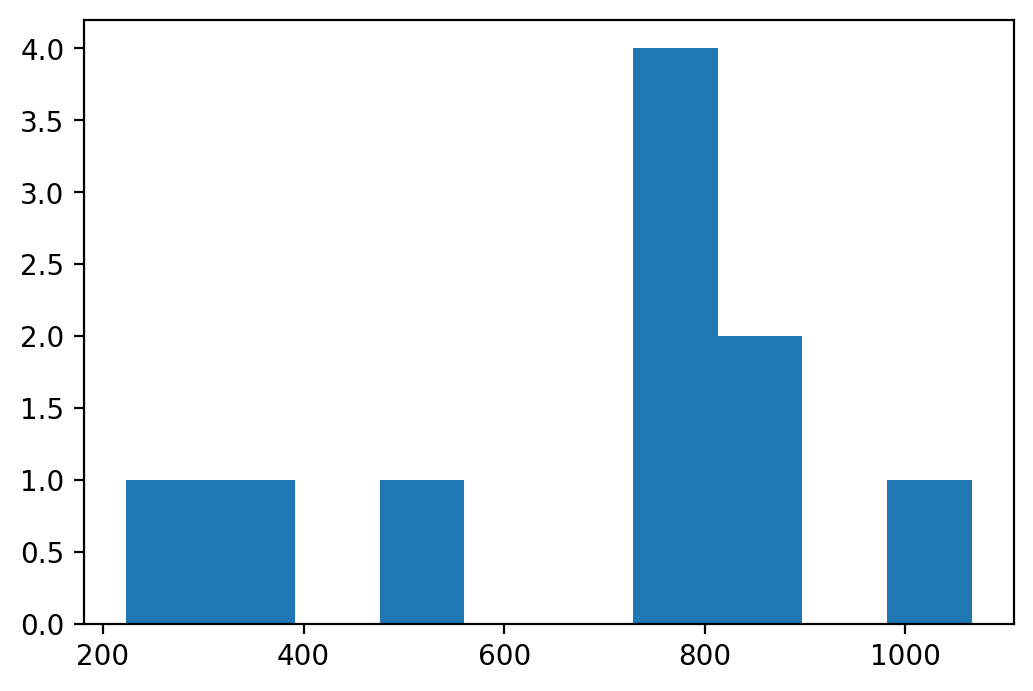

In [36]:
plt.hist(Airline_data['Passenger deaths'])

In [37]:
Airline_data['Passenger deaths'].mean()

691.9

When considering the data, we can see that they are quite dispersed, but in the range from 200 to 1000 focusing more in the upper limits.

In [38]:
Lambda = Airline_data['Passenger deaths'].mean()

In [39]:
with open('PD_PPC.stan', 'r') as file:
    print(file.read())

// Passenger deaths - prior predictive checks
generated quantities {
    // During prior prediction we shouldn't look to data but we don't have to much knowledge about how many people die per year in plane accidents
    // So I decided to use mean value of deaths from data and select wide sigma to catch all possibilities
    real lambda = normal_rng(692,200);
    int deaths = poisson_rng(lambda);
}


In [40]:
model_ppc=stan_utility.compile_model('PD_PPC.stan')

Using cached StanModel


In [41]:
R = 1000
sim = model_ppc.sampling(data=dict(),
                         iter=R,
                         warmup=0,
                         refresh=R,
                         algorithm='Fixed_param',
                         seed=43541)

In [42]:
params_sim=sim.extract()
lambda_sim=params_sim['lambda']
deaths_sim=params_sim['deaths']

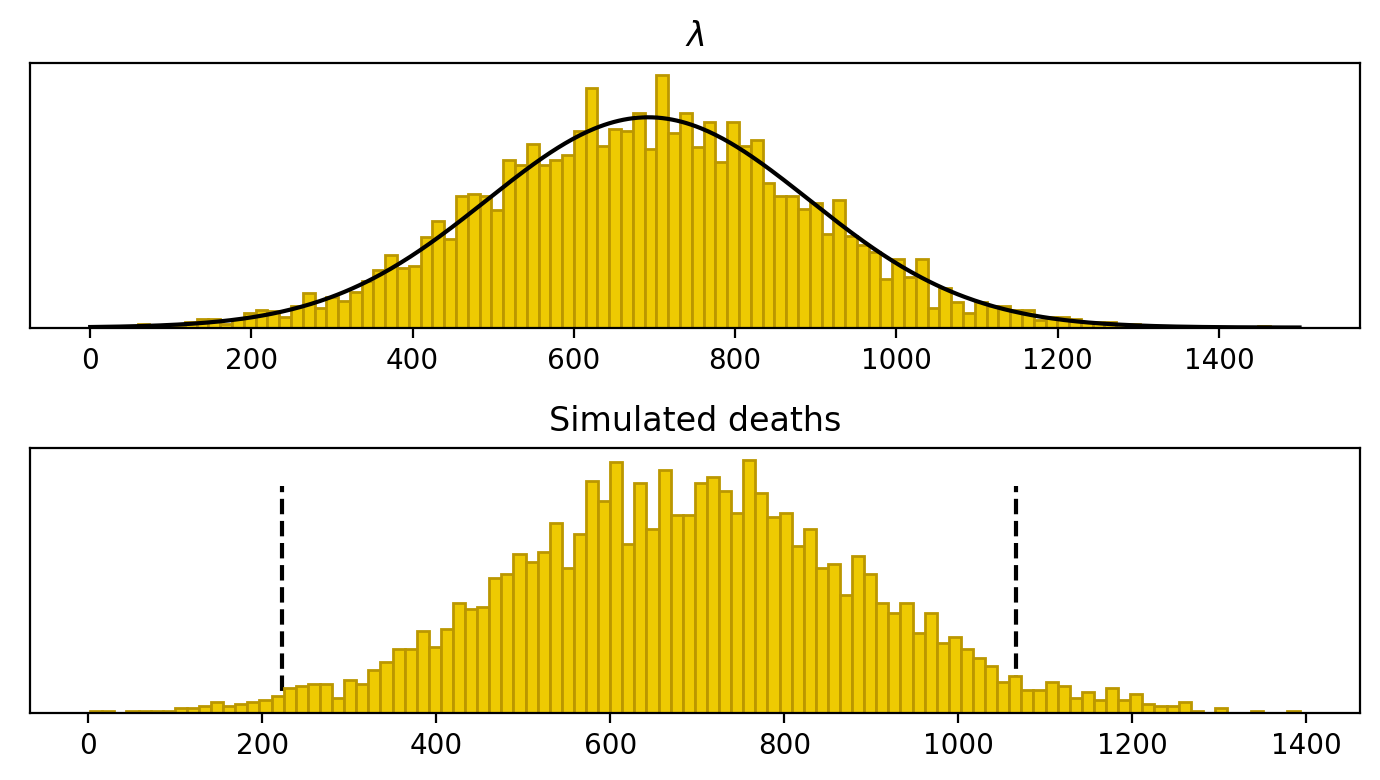

In [43]:
fig = plt.figure(figsize=(7, 4))

gs = fig.add_gridspec(2,1)
ax1 = fig.add_subplot(gs[1])
ax1.hist(deaths_sim,bins=100,color=dark,edgecolor=dark_highlight,density=True)
ax1.vlines([Airline_data['Passenger deaths'].min(),Airline_data['Passenger deaths'].max()],
           ymin=0,ymax=2e-3,linestyle='--',color='black',zorder=1)
# ax1.set_yticks([])
ax1.set_title('Simulated deaths')

ax2 = fig.add_subplot(gs[0])
ax2.hist(lambda_sim,bins=100,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1500,500)
y=stats.norm.pdf(x,loc=692,scale=200)
ax2.plot(x,y,'black')
ax2.set_title('$\lambda$')
ax1.set_yticks([])
ax2.set_yticks([])

fig.tight_layout()
plt.show()

We can se that simulated number of deaths ale mostly between min and max value
and still there is possibility to reach that values so our prior is ok

In [44]:
with open('PD_fit.stan', 'r') as file:
    print(file.read())

data {
    int N; //Number of our samples from data
    int deaths[N]; //Our deaths per year from data
}

parameters{
    real<lower=0> lambda;
}

model {
    lambda ~ normal(692,200);
    deaths ~ poisson(lambda);
}

generated quantities {
    int death = poisson_rng(lambda);
}


In [45]:
model_fit=stan_utility.compile_model('PD_fit.stan')

Using cached StanModel


In [46]:
fit=model_fit.sampling(data=dict(N=len(Airline_data['Passenger deaths']),
                                 deaths=Airline_data['Passenger deaths']),
                       seed=43541)

In [47]:
az.summary(fit,var_names=['lambda'], round_to=2, kind='stats')

,mean,sd,hpd_3%,hpd_97%
lambda,691.69,8.48,676.13,707.69


Mean value is really close to mean value that we assume in the beginning.
It happened because wo shouldn't use data for prior prediction, but we don't have any knowledge about plane death persons so we don't have other choice.
We have to begin with something. 

In [48]:
params_fit=fit.extract()
lambda_fit=params_fit['lambda']
deaths_pred=params_fit['death']

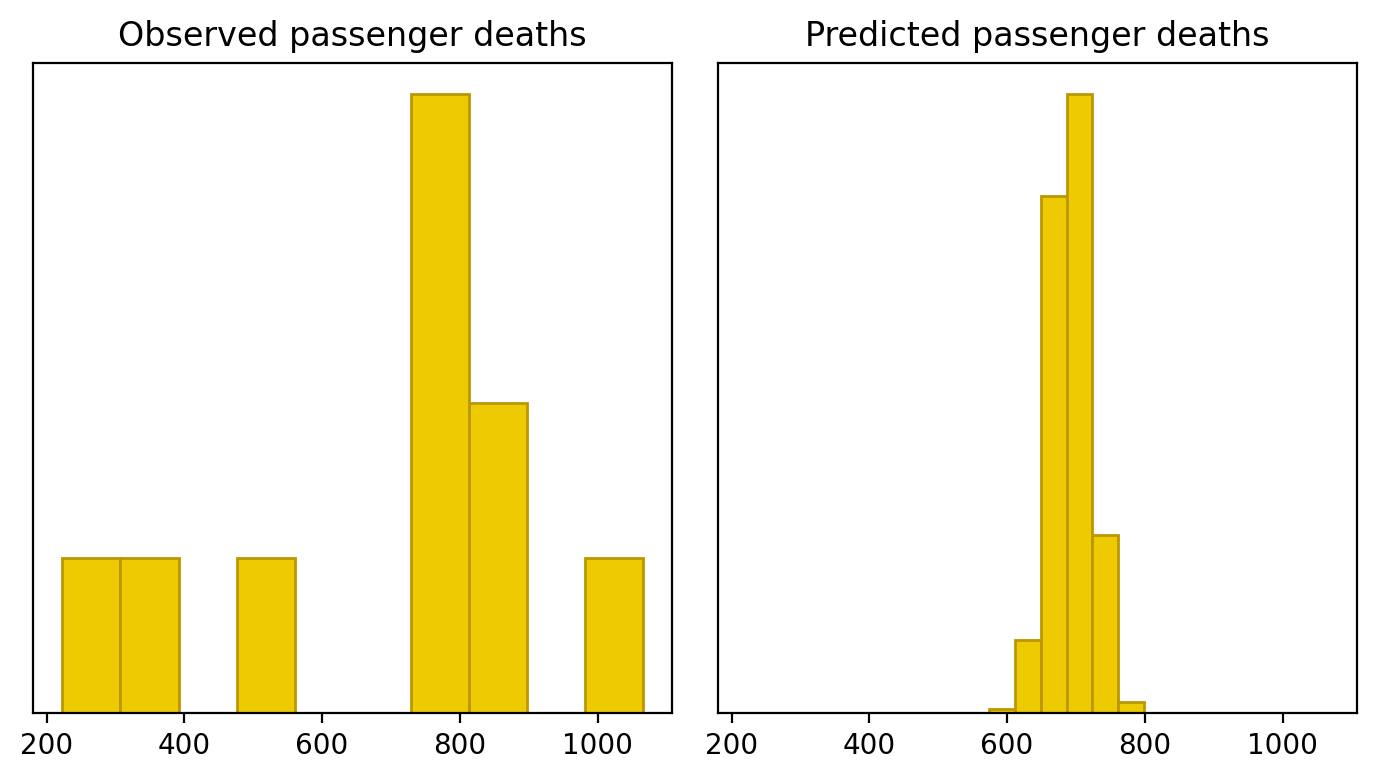

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4),sharex=True)
ax=axes[0]
ax.hist(Airline_data['Passenger deaths'],color=dark,edgecolor=dark_highlight,density=True)
ax.set_title('Observed passenger deaths')
ax.set_yticks(());
ax2=axes[1]
ax2.hist(deaths_pred,bins=6,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('Predicted passenger deaths')
ax2.set_yticks(());
fig.tight_layout()

plt.show()

It's hard to create good prediction with that amount of data, 
but still its not good prediction because we have received model which is focused between 600 and 800.
Real data is much wider then simulated one

## 2. The intensity is constant, but rate is a product of intensity and miles flown.

In [50]:
Intensity = Airline_data['Death rate'].mean()
Intensity

0.126

In [51]:
with open('PD_PPC_rate_as_product.stan', 'r') as file:
    print(file.read())

// Passenger deaths - prior predictive checks with rate as product of intensity and miles flown

data {
    int N;
    real Miles[N];
}

generated quantities {
    // beta is our intensity
    // We also use beta distribution because it is in interval 0 to 1 and we dont expect more then 1 dead people per 100 mld miles flown
    // Also its impossible to get - death ratio co 0 limit is perfect for us.
    // Additionally we want to focus rather values around 0,2 then 0,8 that why I decided to use alpha=2 and beta=10 parameters
    real beta = beta_rng(2,10);
    int deaths[N];
    for(i in 1:N) {
        deaths[i] = poisson_rng(Miles[i]*beta);
    }

}


In [52]:
model_ppc_rate=stan_utility.compile_model('PD_PPC_rate_as_product.stan')

Using cached StanModel


In [53]:
R=1000
data_sim=dict(N=50,
              Miles=np.linspace(Airline_data['Miles flown [100 mln miles]'].min(),
                                Airline_data['Miles flown [100 mln miles]'].max()))
                                   
rate_sim = model_ppc_rate.sampling(data=data_sim,
                                   iter=R,
                                   warmup=0,
                                   chains=1,
                                   refresh=R,
                                   algorithm='Fixed_param',
                                   seed=43541)

In [54]:
params_rate_sim=rate_sim.extract()
beta_sim=params_rate_sim['beta']

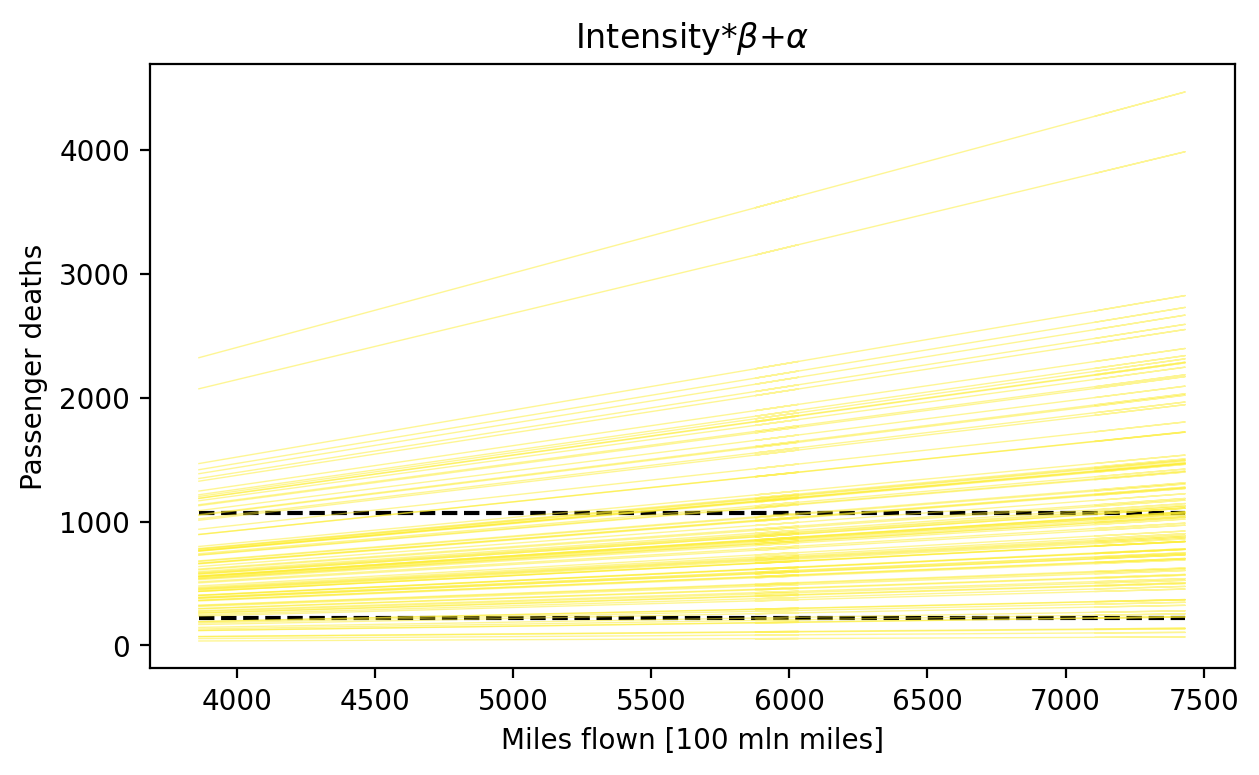

In [55]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines([Airline_data['Passenger deaths'].min(),
             Airline_data['Passenger deaths'].max()],
            xmin=Airline_data['Miles flown [100 mln miles]'].min(),
            xmax=Airline_data['Miles flown [100 mln miles]'].max(),
            linestyles='--',
            colors='black')
for i in range(100):
    axes.plot(Airline_data['Miles flown [100 mln miles]'],
              beta_sim[i]*Airline_data['Miles flown [100 mln miles]'],
              color=mid,
              alpha=0.5,
              linewidth=0.5)
axes.set_xlabel('Miles flown [100 mln miles]')
axes.set_ylabel('Passenger deaths')
axes.set_title(r'Intensity*$\beta$+$\alpha$')
plt.show()

Its not perfectly fit but conditions are met for most of lines.
Also all of the possibilities isn't abnormal.
We dont get extremely high amount of deaths so conditions are at least possible.

In [56]:
deaths_rate_sim=params_rate_sim['deaths']

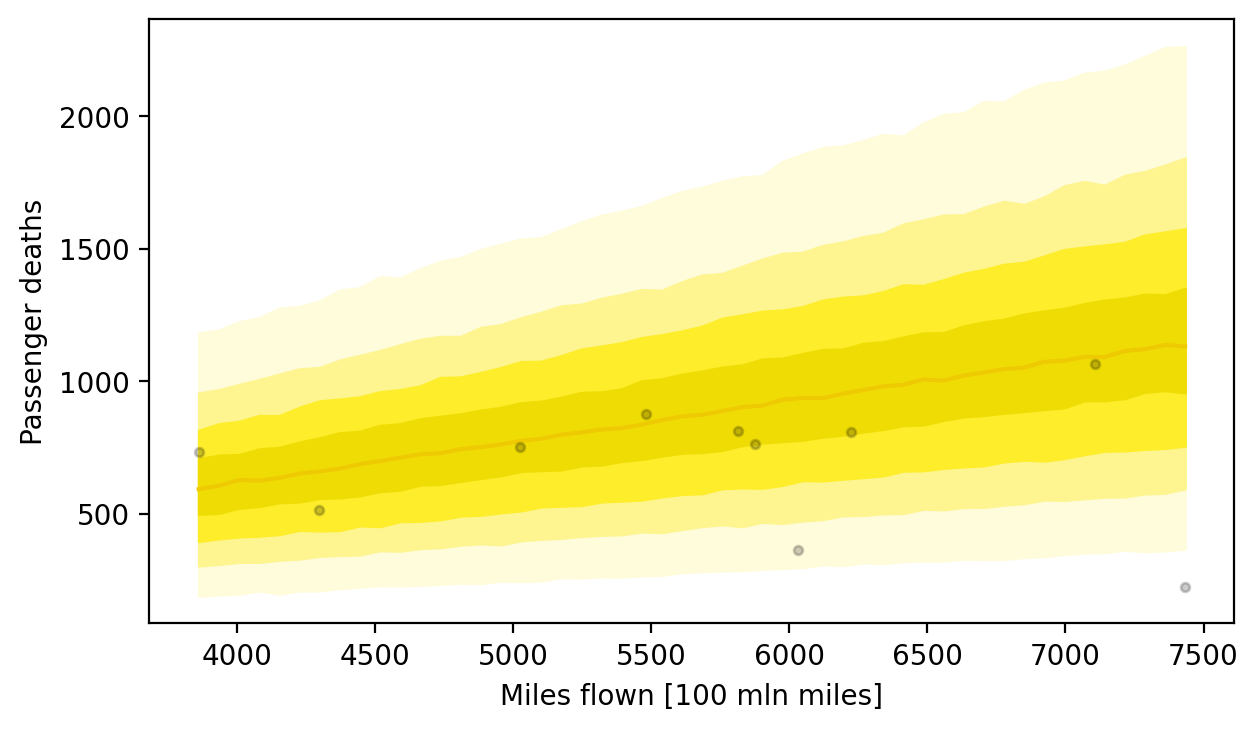

In [57]:
fig, axes = plt.subplots(1, 1, figsize=(7,4))
axes = ribbon_plot(data_sim['Miles'],deaths_rate_sim,axes)
axes.scatter(Airline_data['Miles flown [100 mln miles]'],
             Airline_data['Passenger deaths'],
             color='black',
             alpha=0.2,
             s=10)
axes.set_xlabel('Miles flown [100 mln miles]')
axes.set_ylabel('Passenger deaths')
plt.show()

We can se that our prior behave very well for that amount of samples it covers almost all of them with mean value close to most of the samples.

In [58]:
with open('PD_rate_fit.stan', 'r') as file:
    print(file.read())

data {
    int N; //Number of our samples from data
    int deaths[N]; //Our deaths per year from data
    vector[N] Miles;
}

parameters{
    real beta;
}

transformed parameters {
    vector[N] lambda = Miles*beta;
}

model {
    beta ~ beta(2,10);
    deaths ~ poisson(lambda);
}

generated quantities {
    int death[N];
    for (i in 1:N) {
        death[i] = poisson_rng(lambda[i]);
    }

}


In [59]:
model_rate_fit = stan_utility.compile_model('PD_rate_fit.stan')

Using cached StanModel


In [60]:
data_fit=dict(N=len(Airline_data),
              deaths=Airline_data['Passenger deaths'],
              Miles=Airline_data['Miles flown [100 mln miles]'])

rate_fit=model_rate_fit.sampling(data=data_fit,
                                 seed=43541)

In [61]:
params_rate_fit=rate_fit.extract()
beta_rate_fit=params_rate_fit['beta']
lambda_rate_fit=params_rate_fit['lambda']
deaths_rate_pred=params_rate_fit['death']

In [62]:
az.summary(rate_fit,
           var_names=['beta', 'lambda'],
           round_to=2,
           kind='stats')

,mean,sd,hpd_3%,hpd_97%
beta,0.12,0.00,0.12,0.12
lambda[0],467.62,5.82,456.90,478.52
lambda[1],520.52,6.48,508.59,532.65
lambda[2],608.53,7.57,594.58,622.71
lambda[3],663.48,8.26,648.28,678.95
lambda[4],703.79,8.76,687.66,720.20
lambda[5],730.30,9.09,713.57,747.32
lambda[6],711.42,8.85,695.11,728.00
lambda[7],753.30,9.38,736.04,770.86
lambda[8],899.77,11.20,879.15,920.75


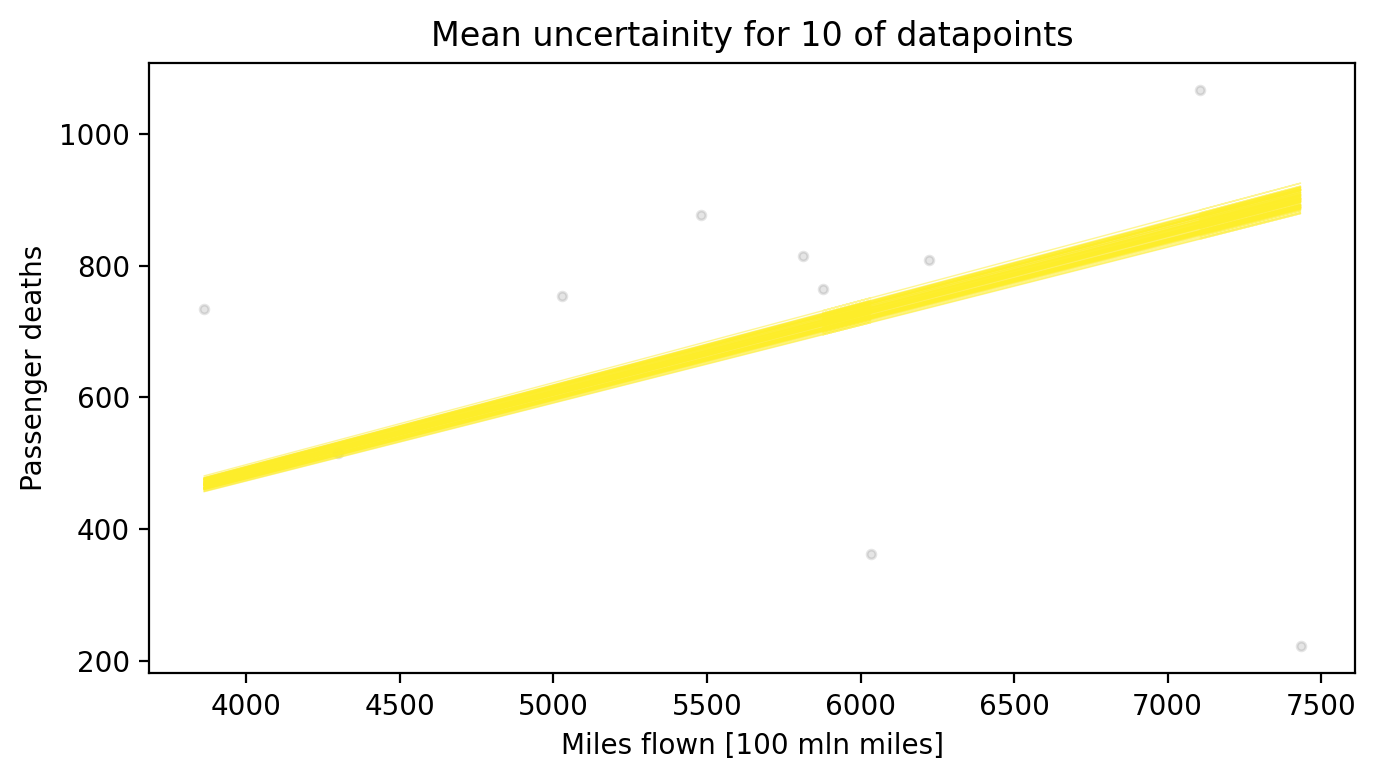

In [63]:
fig, axes = plt.subplots(1,1, figsize=(7, 4),sharey=True,sharex=True)
for i in range(100):
    axes.plot(Airline_data['Miles flown [100 mln miles]'],
              beta_rate_fit[i]*Airline_data['Miles flown [100 mln miles]'],
              color=mid,
              alpha=0.5,
              linewidth=0.5)
axes.scatter(Airline_data['Miles flown [100 mln miles]'],Airline_data['Passenger deaths'],color='black',alpha=0.1,s=10)
axes.set_ylabel('Passenger deaths')
axes.set_xlabel('Miles flown [100 mln miles]')
axes.set_title('Mean uncertainity for {} of datapoints'.format(len(Airline_data)))
fig.tight_layout()
plt.show()

Sorting


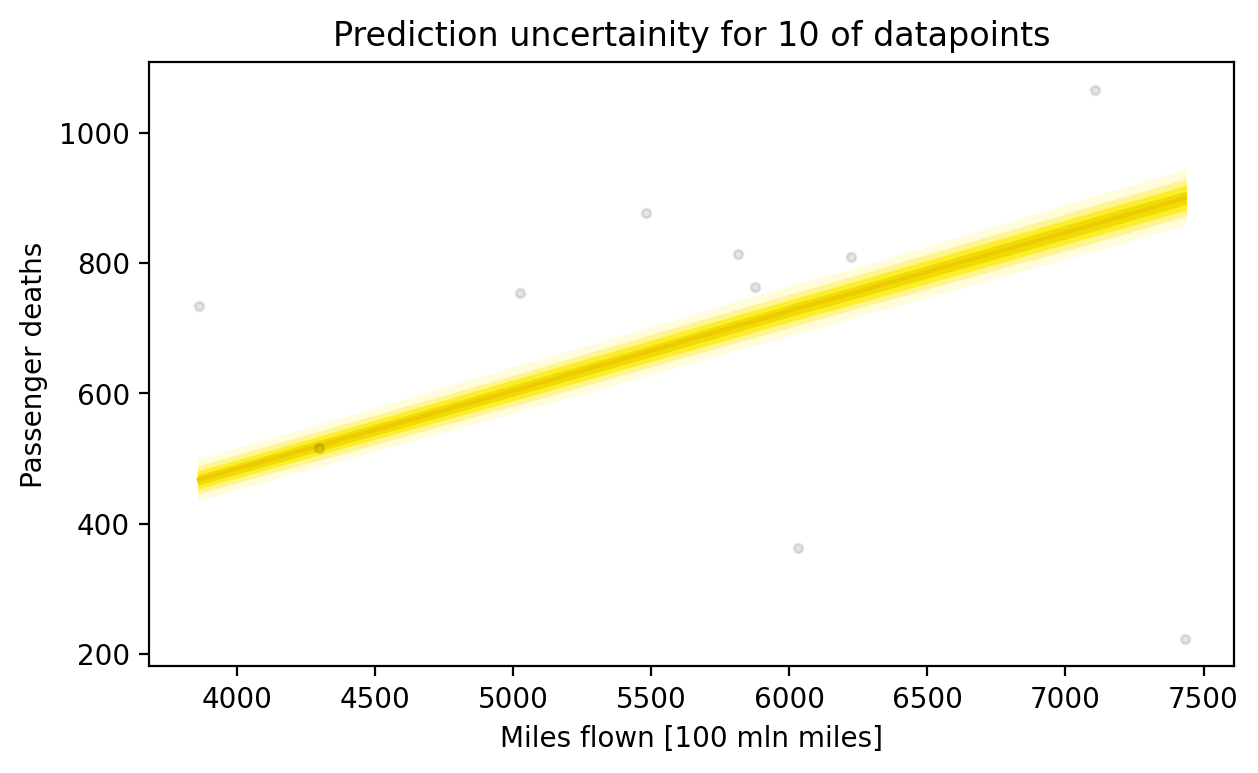

In [64]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(Airline_data['Miles flown [100 mln miles]'].values,deaths_rate_pred,axes)
axes.scatter(Airline_data['Miles flown [100 mln miles]'],Airline_data['Passenger deaths'],color='black',alpha=0.1,s=10)
axes.set_ylabel('Passenger deaths')
axes.set_xlabel('Miles flown [100 mln miles]')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(Airline_data)))
plt.show()

So as we can se that model fit data much better it's still quite far away to perfect describe the situation.
That happened because we have just 10 samples and if we look into our data death ratio isn't constant it rather have quite huge standard variance.
So to improve our model we can consider variant intensity. 
Also we can consider more factors like fact that every year safety for planes are getting better so death ratio should decrease over years.
